In [2]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
%matplotlib inline

### Get the crime data from the following url

In [ ]:
url = 'https://data.cityofnewyork.us/api/views/8h9b-rp9u/rows.csv?accessType=DOWNLOAD'
raw_data = pd.read_csv(url)

### Data cleaning

In [ ]:
raw_data.sort_values('ARREST_DATE')

In [ ]:
raw_data['ARREST_DATE'] = pd.to_datetime(raw_data['ARREST_DATE'])
raw_data_2018 = raw_data[raw_data['ARREST_DATE'].astype('datetime64[Y]') == np.datetime64('2018')]
raw_data_2018.head()

In [ ]:
filtered_cols = ['ARREST_DATE', 'OFNS_DESC', 'Latitude', 'Longitude']
nyc_crime_2018 = raw_data_2018.loc[:,filtered_cols].reset_index(drop = True)
nyc_crime_2018.head()

In [ ]:
nyc_crime_2018.groupby('OFNS_DESC').count().sort_values('ARREST_DATE', ascending = False).head(10)

### Only robberies were extracted from the original dataset

In [ ]:
nyc_robbery_2018 = nyc_crime_2018[nyc_crime_2018['OFNS_DESC'] == 'ROBBERY'].reset_index(drop = True)
nyc_robbery_2018.head(10)

### Create x,y coordinates from latitudes and longitudes for each point

In [ ]:
import pyproj as proj

crs_wgs = proj.Proj(init='epsg:4326')
crs_nyw = proj.Proj(init='epsg:32117')

x, y = proj.transform(crs_wgs, crs_nyw, nyc_robbery_2018['Longitude'].values, nyc_robbery_2018['Latitude'].values)

nyc_robbery_2018['x_coord'] = x
nyc_robbery_2018['y_coord'] = y

nyc_robbery_2018.head(10)

### Export the preprocessed dataset for easy access

In [ ]:
nyc_robbery_2018.to_csv('nyc_robbery_2018.csv')

In [4]:
nyc_robbery_2018 = pd.read_csv('nyc_robbery_2018.csv')

### Perform DBSCAN clustering on the robbery dataset

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

cluster_dataset = nyc_robbery_2018[['x_coord', 'y_coord']]
cluster_dataset = StandardScaler().fit_transform(cluster_dataset)

db = DBSCAN(eps = 0.05, min_samples = 20)
db.fit(cluster_dataset)
labels = db.labels_

nyc_robbery_2018['Label'] = labels
kclusters = len(set(labels))

nyc_robbery_2018.head(10)

Unnamed: 0 ARREST_DATE OFNS_DESC   Latitude  Longitude        x_coord  \
0           0  2018-12-31   ROBBERY  40.673553 -73.866670  748832.285509   
1           1  2018-12-31   ROBBERY  40.733927 -73.871582  748056.194523   
2           2  2018-12-31   ROBBERY  40.851810 -73.909219  744175.993702   
3           3  2018-12-31   ROBBERY  40.863086 -73.925693  742719.503585   
4           4  2018-12-31   ROBBERY  40.816981 -73.921152  743375.630772   
5           5  2018-12-31   ROBBERY  40.884494 -73.905601  744286.770472   
6           6  2018-12-31   ROBBERY  40.665503 -73.884745  747351.275963   
7           7  2018-12-31   ROBBERY  40.665503 -73.884745  747351.275963   
8           8  2018-12-31   ROBBERY  40.881982 -73.830182  750661.083278   
9           9  2018-12-31   ROBBERY  40.814094 -73.959298  740172.990674   

         y_coord  Label  
0   85499.716036     -1  
1   92184.791880     -1  
2  105110.962124     -1  
3  106289.509355     -1  
4  101187.687260      0  
5  108758.379584      1  
6   84523.311225     23  
7   84523.311225     23  
8  108822.562889     -1  
9  100696.046931      2

### Visualize the DBSCAN clustering results on map (non-cluster points not shown)

In [6]:
from matplotlib import cm
import matplotlib.colors as cls

nyc_map = folium.Map(location = [40.681761, -73.967480], zoom_start = 12)

colors = cm.rainbow(np.linspace(0,1,kclusters-1))
latitudes = nyc_robbery_2018.loc[:,'Latitude']
longitudes = nyc_robbery_2018.loc[:,'Longitude']
descs = nyc_robbery_2018.loc[:,'OFNS_DESC']
dates = nyc_robbery_2018.loc[:,'ARREST_DATE']
clusters = nyc_robbery_2018.loc[:,'Label']

for latitude, longitude, desc, date, cluster in zip(latitudes, longitudes, descs, dates, clusters):
    if str(cluster) != '-1':
        label = folium.Popup(str(date) + ',' + str(desc) + ',' + 'cluster: {}'.format(str(cluster)))
        folium.CircleMarker(
            location = [latitude, longitude],
            radius = 1,
            popup = label,
            color = cls.rgb2hex(colors[cluster]),
            fill = True,
            fill_color = cls.rgb2hex(colors[cluster]),
            fill_opacity=0.7).add_to(nyc_map)

nyc_map

### Get the number of robberies for each cluster

In [6]:
groups = nyc_robbery_2018.groupby('Label').count().iloc[1:,0:1].reset_index()
groups.columns = ['Label', 'Count']
groups.head()

Label  Count
0      0    309
1      1     39
2      2    315
3      3     23
4      4    118

### Calculate the centroid and convex hull area for each cluster

In [7]:
from scipy.spatial import ConvexHull

areas = []
center_lat = []
center_long = []

for label in set(nyc_robbery_2018['Label'].values):
    if label != -1:
        label_group = nyc_robbery_2018[nyc_robbery_2018['Label'] == label]
        center_lat.append(np.mean(label_group['Latitude']))
        center_long.append(np.mean(label_group['Longitude']))
        # Calculate the centroid of each cluster
        try:
            label_group_hull = ConvexHull(label_group[['x_coord','y_coord']].values)
            areas.append(label_group_hull.area)
        except:
            areas.append(0)
        # Calculate the convex hull area of each cluster.
        # If the cluster cannot form a convex hull, the area is set to 0.

groups['Center Latitude'] = center_lat
groups['Center Longitude'] = center_long
groups['Area'] = areas
groups = groups[groups['Area'] != 0]
    # Drop rows with area equals to 0
groups.head()

Label  Count  Center Latitude  Center Longitude         Area
0      0    309        40.814684        -73.920062  5979.788293
1      1     39        40.883147        -73.903487   802.784708
2      2    315        40.816792        -73.948283  8732.949515
4      4    118        40.823617        -73.870242  2133.276493
5      5     31        40.649825        -74.006771  2841.678924

### Foursquare API keys

In [8]:
import json
import requests
from pandas.io.json import json_normalize

In [9]:
CLIENT_ID = '1BOLDFOSJ4JNUULUEH4LDAMG4X40I0VWMQKIDCHNEJ4RJMLA'
CLIENT_SECRET = '4PRFRPNP451CQGFQTT2CIJGSOJE3JIFX5QXATUGPVK4QPW0U'
VERSION = '20200329'
LIMIT = 100

### Function to get the categories from API results

In [10]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Define a function to make API calls, clean the json and structure it into dataframe for each cluster

In [17]:
def getNearbyVenues(labels, lats, lngs, radius = 500):
    
    all_venues = pd.DataFrame()
    
    # Make API calls for each postcode and get results
    for label, latitude, longitude in zip(labels, lats, lngs):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            latitude, 
            longitude, 
            VERSION, 
            radius, 
            LIMIT)
        results = requests.get(url).json()
        venues = results['response']['groups'][0]['items']
        
        # Clean the results from each API call and structure it to pandas DataFrames
        if venues != []:
            nearby_venues = json_normalize(venues)
            filtered_cols = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
            nearby_venues = nearby_venues.loc[:, filtered_cols]
            nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
            nearby_venues.columns = ['Venue Name', 'Venue Categories', 'Venue Latitude', 'Venue Longitude']
            nearby_venues['Label'] = [label for i in range(len(nearby_venues))]
        
            all_venues = pd.concat([all_venues, nearby_venues], axis = 0, sort = False)
        
        # If there are no venues found in the cluster
        else:
            print('No venues found for cluster ' + cluster)
        
        all_venues.reset_index(inplace = True, drop = True)
    
    return all_venues

In [18]:
clusters = groups.loc[:,'Label']
lats = groups.loc[:,'Center Latitude']
lngs = groups.loc[:,'Center Longitude']
all_venues = getNearbyVenues(clusters, lats, lngs)

In [19]:
all_venues.head()

Venue Name    Venue Categories  Venue Latitude  \
0  Bronx Documentary Center         Art Gallery       40.818003   
1         Opera House Hotel               Hotel       40.815250   
2       Mexicozina Taqueria  Mexican Restaurant       40.814964   
3                 La Morada  Mexican Restaurant       40.810670   
4                Mexicocina  Mexican Restaurant       40.815092   

   Venue Longitude  Label  
0       -73.918864      0  
1       -73.916090      0  
2       -73.915797      0  
3       -73.921758      0  
4       -73.915869      0

In [20]:
all_venues.shape

(3622, 5)

### Calculate the frequency of each category of venues and the density of robberies in each cluster

In [21]:
venues_dist = pd.get_dummies(all_venues['Venue Categories'])
venues_dist['Label'] = all_venues['Label']

rearranged_cols = list(venues_dist.columns[-1:]) + list(venues_dist.columns[:-1])
venues_dist = venues_dist[rearranged_cols]
venues_dist.head()

Label  Accessories Store  Adult Boutique  Afghan Restaurant  \
0      0                  0               0                  0   
1      0                  0               0                  0   
2      0                  0               0                  0   
3      0                  0               0                  0   
4      0                  0               0                  0   

   African Restaurant  American Restaurant  Antique Shop  Arcade  \
0                   0                    0             0       0   
1                   0                    0             0       0   
2                   0                    0             0       0   
3                   0                    0             0       0   
4                   0                    0             0       0   

   Arepa Restaurant  Argentinian Restaurant  ...  Video Store  \
0                 0                       0  ...            0   
1                 0                       0  ...            0   
2                 0                       0  ...            0   
3                 0                       0  ...            0   
4                 0                       0  ...            0   

   Vietnamese Restaurant  Warehouse Store  Weight Loss Center  Whisky Bar  \
0                      0                0                   0           0   
1                      0                0                   0           0   
2                      0                0                   0           0   
3                      0                0                   0           0   
4                      0                0                   0           0   

   Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  
0         0          0            0              0            0  
1         0          0            0              0            0  
2         0          0            0              0            0  
3         0          0            0              0            0  
4         0          0            0              0            0  

[5 rows x 343 columns]

In [27]:
venues_freq = venues_dist.groupby('Label').mean()
groups_with_venues = groups.join(venues_freq, on = 'Label').reset_index(drop = True)
groups_with_venues['Density'] = groups_with_venues['Count']/groups_with_venues['Area']

Label  Count  Center Latitude  Center Longitude         Area  \
0       0    309        40.814684        -73.920062  5979.788293   
1       1     39        40.883147        -73.903487   802.784708   
2       2    315        40.816792        -73.948283  8732.949515   
3       4    118        40.823617        -73.870242  2133.276493   
4       5     31        40.649825        -74.006771  2841.678924   
..    ...    ...              ...               ...          ...   
67     77     28        40.668581        -73.905846  2143.361446   
68     78     21        40.653086        -73.959915  1742.247209   
69     79     21        40.703359        -73.940421  1909.680871   
70     80     19        40.693951        -73.936561  1950.666060   
71     81     20        40.765579        -73.932265  1208.264114   

    Accessories Store  Adult Boutique  Afghan Restaurant  African Restaurant  \
0                 0.0             0.0                0.0            0.000000   
1                 0.0             0.0                0.0            0.000000   
2                 0.0             0.0                0.0            0.042553   
3                 0.0             0.0                0.0            0.000000   
4                 0.0             0.0                0.0            0.000000   
..                ...             ...                ...                 ...   
67                0.0             0.0                0.0            0.000000   
68                0.0             0.0                0.0            0.000000   
69                0.0             0.0                0.0            0.000000   
70                0.0             0.0                0.0            0.000000   
71                0.0             0.0                0.0            0.000000   

    American Restaurant  ...  Vietnamese Restaurant  Warehouse Store  \
0              0.000000  ...                    0.0         0.000000   
1              0.000000  ...                    0.0         0.015152   
2              0.042553  ...                    0.0         0.000000   
3              0.000000  ...                    0.0         0.000000   
4              0.000000  ...                    0.0         0.000000   
..                  ...  ...                    ...              ...   
67             0.000000  ...                    0.0         0.000000   
68             0.000000  ...                    0.0         0.000000   
69             0.000000  ...                    0.0         0.000000   
70             0.000000  ...                    0.0         0.000000   
71             0.000000  ...                    0.0         0.000000   

    Weight Loss Center  Whisky Bar  Wine Bar  Wine Shop  Wings Joint  \
0                  0.0    0.000000       0.0   0.000000     0.000000   
1                  0.0    0.000000       0.0   0.000000     0.015152   
2                  0.0    0.000000       0.0   0.000000     0.000000   
3                  0.0    0.000000       0.0   0.000000     0.000000   
4                  0.0    0.000000       0.0   0.000000     0.000000   
..                 ...         ...       ...        ...          ...   
67                 0.0    0.000000       0.0   0.000000     0.000000   
68                 0.0    0.000000       0.0   0.013514     0.000000   
69                 0.0    0.000000       0.0   0.000000     0.000000   
70                 0.0    0.022727       0.0   0.000000     0.000000   
71                 0.0    0.000000       0.0   0.037037     0.000000   

    Women's Store  Yoga Studio   Density  
0             0.0          0.0  0.051674  
1             0.0          0.0  0.048581  
2             0.0          0.0  0.036070  
3             0.0          0.0  0.055314  
4             0.0          0.0  0.010909  
..            ...          ...       ...  
67            0.0          0.0  0.013064  
68            0.0          0.0  0.012053  
69            0.0          0.0  0.010997  
70            0.0          0.0  0.009740  
71            0.0      

### Now let's see the density of which categories of venues influence the density of robberies the most

In [91]:
density_with_venues = groups_with_venues.iloc[:,5:]
corrs = density_with_venues.corr().iloc[:,-1]
corrs = corrs.sort_values(ascending = False)
print('Top positive corr:')
print(corrs.head())
print('')
print('Top negative corr:')
print(corrs.tail())

Top positive corr:
Density              1.000000
Drugstore            0.750248
Music Store          0.573311
Steakhouse           0.465132
Convenience Store    0.347535
Name: Density, dtype: float64

Top negative corr:
Coffee Shop            -0.212605
Gym / Fitness Center   -0.217583
Bakery                 -0.223395
Cocktail Bar           -0.228865
Indian Restaurant      -0.261243
Name: Density, dtype: float64


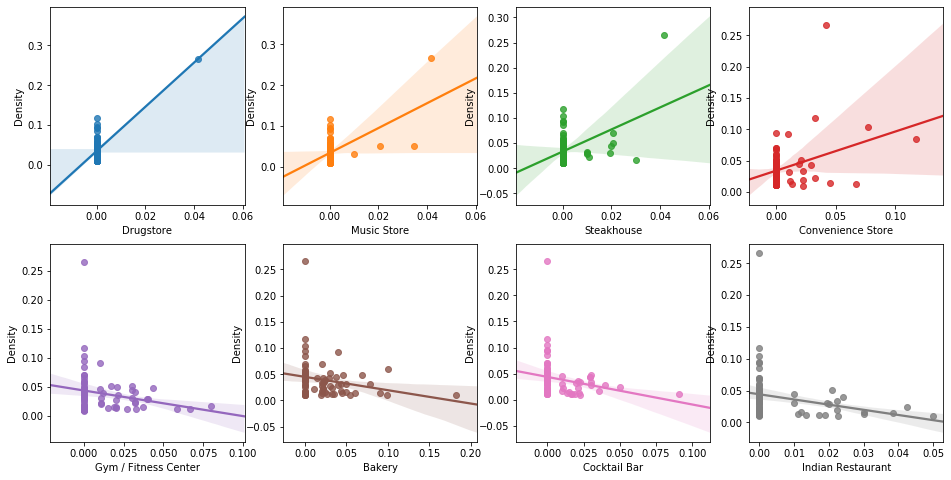

In [103]:
import seaborn as sns
cols = ['Drugstore','Music Store','Steakhouse','Convenience Store','Gym / Fitness Center','Bakery','Cocktail Bar','Indian Restaurant']
fig, axes = plt.subplots(2,4)
fig.set_size_inches(16,8)
for i, col in enumerate(cols):
    sns.regplot(data = density_with_venues, x = col, y = 'Density', ax = axes[i//4,i%4])

### Train a regression model for the prediction of robbery densities.
### According to the analysis above, 8 categories of venues were chosen as features, 4 with the highest positive correlation coefficients and 4 with the highest negative correlation coefficients

In [111]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X = scaler.fit_transform(density_with_venues[cols])
y = density_with_venues['Density'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(54, 8)
(18, 8)
(54,)
(18,)


### Linear model

In [120]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)

### Assessment of the linear model

In [121]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('r2 score: ', r2_score(y_test, y_predict))
print('Root of Mean Squared Error: ', np.sqrt(mean_squared_error(y_test, y_predict)))

r2 score:  0.3367765215196421
Root of Mean Squared Error:  0.019647028288613227


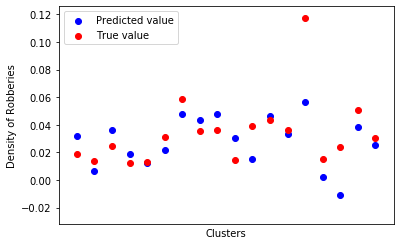

In [126]:
plt.scatter(np.arange(18),y_predict,color = 'b')
plt.scatter(np.arange(18),y_test,color = 'r')
plt.xlabel('Clusters')
plt.xticks([])
plt.ylabel('Density of Robberies')
plt.legend(('Predicted value','True value'))

### K-Nearest-Neighbors model

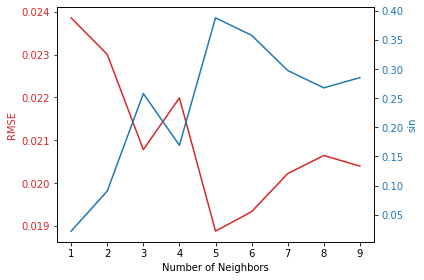

In [147]:
from sklearn.neighbors import KNeighborsRegressor

r2_scores = []
rmse = []
for k in np.arange(1,10):
    knr = KNeighborsRegressor(n_neighbors = k)
    knr.fit(X_train, y_train)
    y_predict = knr.predict(X_test)
    
    r2_scores.append(r2_score(y_test, y_predict))
    rmse.append(np.sqrt(mean_squared_error(y_test, y_predict)))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Neighbors')
ax1.set_ylabel('RMSE', color=color)
ax1.plot(np.arange(1,10), rmse, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(1,10), r2_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipper

r2 score:  0.38762905045748
Root of Mean Squared Error:  0.018878792555466675


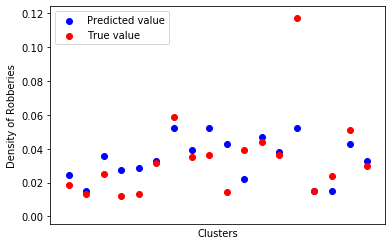

In [148]:
knr = KNeighborsRegressor(n_neighbors = 5)
knr.fit(X_train, y_train)
y_predict = knr.predict(X_test)

print('r2 score: ', r2_score(y_test, y_predict))
print('Root of Mean Squared Error: ', np.sqrt(mean_squared_error(y_test, y_predict)))

plt.scatter(np.arange(18),y_predict,color = 'b')
plt.scatter(np.arange(18),y_test,color = 'r')
plt.xlabel('Clusters')
plt.xticks([])
plt.ylabel('Density of Robberies')
plt.legend(('Predicted value','True value'))